### The idea

The term fake news gained prominence during the last US election, but have been around for a while. The problem is that now they have saturated the media landscape with ever more scandalous titles, and have reached a point where it is difficult to tell the fake from real. They are widely used for political purposes and supposedly shaped the last US elections and are part of the widespread russian hybrid war. 

The goal of this "excercise" is to explore these fake news: Where do they come from? What is in them? What topics get the most involvement? Finally I will try to build a classifier that tries to tell fake from clickbait from real news, and a fake news generator, that will hopefully capture the essence

### Plan of attack 

1. Which media have the most fake news in the dataset?
    Looks like the way the dataset is constructed you get at most 100 titles from a media. So not the best metric        
2. What are the most common words and bigrams you find in titles? 
3. What are the most common words and bigrams you find in texts?
4. What topics get the most interest (likes, shares and comments)?:
    - Need to figure out how to determine topics.
5. Which medias get the most interest (likes, shares and comments)?
6. Can we build fake news classifier:
    - Need to get non-fake-news data.
    - Would it work by title only?
    - Classify fake news, clickbait, real_news
    - T-SNE, clustering and other visualisation. 
    - Word distributions in different groups
    - Deep vs traditional
    - word2vec vs. tf-idf
7. How often do capital letters appear in titles? Can we use these as a predictor?
8. What do the texts of the articles tell us - can we find common patterns, topics, etc.?
9. Can we build a fake news generator?
    - GAN? 
    - RNN or something?
10. Obtain more news to see if the set reflects current state of fake news media. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
stopwords = list(set(stopwords.words('english')))
stopwords.extend(['-', '&', '|'])
sns.set()

In [34]:
# Prepare and clean data
data = pd.read_csv("fake.csv", header=0)
print(set(data.language))
print(set(data.type))
# We want only english on this one. Unfortunately reduces the dataset down to a third of its original size
data = data[data.language == 'english'] 
data = data.dropna()

{'spanish', 'german', 'polish', 'chinese', 'french', 'ignore', 'english', 'portuguese', 'norwegian', 'finnish', 'arabic', 'italian', 'turkish', 'greek', 'dutch', 'russian'}
{'satire', 'conspiracy', 'state', 'bs', 'bias', 'fake', 'hate', 'junksci'}


In [35]:
data.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [5]:
titles = [x.lower() for x in list(data[['title']].title)]
vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                             stop_words=stopwords)
transformed_titles = vectorizer.fit_transform(titles)
inverse = [(value, key) for key, value in vectorizer.vocabulary_.items()]
inverse = sorted(inverse, key=lambda x: x[0])
print(inverse[-100:])
#What do I do with these? Dunno yet. 

312795


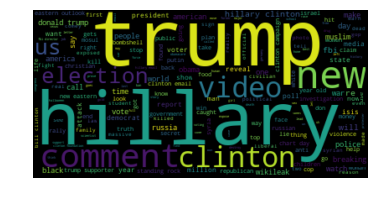

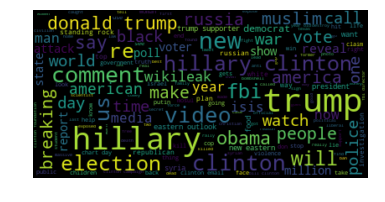

In [8]:
# Word cloud from titles. Very political.
# TODO: Investgate how much this reflects current situation
concat_titles = ' '.join(titles)
concat_titles = concat_titles.lower()
print(len(concat_titles))
wordcloud = WordCloud().generate(concat_titles)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(concat_titles)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
fdist = nltk.FreqDist([x for x in concat_titles.split(" ") if x not in stopwords])
print(fdist.most_common(100))

[('trump', 529), ('hillary', 457), ('clinton', 342), ('new', 219), ('comment', 214), ('–', 185), ('fbi', 172), ('election', 147), ('us', 133), ('re:', 113), ('obama', 112), ('donald', 100), ('(video)', 98), ('campaign', 80), ('people', 80), ('police', 77), ('muslim', 77), ('one', 75), ('hillary’s', 74), ('email', 73), ('says', 73), ('war', 71), ('black', 68), ('world', 67), ('russia', 65), ('breaking:', 64), ('emails', 64), ('media', 61), ('state', 60), ('investigation', 58), ('white', 58), ('trump’s', 58), ('vote', 56), ('could', 55), ('news', 53), ('—', 53), ('wikileaks', 51), ('u.s.', 51), ('make', 50), ('get', 49), ('voting', 49), ('it’s', 48), ('eastern', 48), ('clinton’s', 47), ('america', 46), ('president', 45), ('man', 45), ('isis', 44), ('outlook', 44), ('real', 43), ('know', 43), ('first', 43), ('watch:', 42), ('russian', 42), ('day', 42), ('chart', 42), ('comey', 42), ('caught', 41), ('calls', 41), ('water', 41), ('standing', 41), ('gets', 41), ('time', 40), ('reveals', 40),

In [11]:
words = [x for x in concat_titles.split(" ") if x not in stopwords]
big = list(nltk.bigrams(words))
fdist = nltk.FreqDist(big)
print(fdist.most_common(100))

[(('hillary', 'clinton'), 111), (('donald', 'trump'), 70), (('new', 'eastern'), 44), (('eastern', 'outlook'), 44), (('standing', 'rock'), 37), (('chart', 'day:'), 37), (('fbi', 'director'), 25), (('clinton', 'campaign'), 23), (('hillary', 'clinton’s'), 23), (('clinton', 'foundation'), 22), (('trump', 'supporters'), 21), (('daily', 'contrarian'), 21), (('contrarian', 'reads'), 21), (('bill', 'clinton'), 20), (('trump', 'supporter'), 19), (('white', 'house'), 17), (('supreme', 'court'), 17), (('election', 'day'), 16), (('dakota', 'access'), 16), (('clinton', 'email'), 16), (('email', 'investigation'), 15), (('world', 'war'), 15), (('george', 'soros'), 15), (('·', 'guardian'), 15), (('guardian', 'liberty'), 15), (('liberty', 'voice'), 15), (('access', 'pipeline'), 14), (('–', 'collective'), 14), (('clinton', 'emails'), 14), (('huma', 'abedin'), 13), (('collective', 'evolution'), 13), (('water', 'cooler'), 13), (('»', '100percentfedup.com'), 12), (('voting', 'machines'), 12), (('michelle',

In [37]:
# likes and shares. 
shared_data = data[['uuid', 'site_url', 'likes', 'shares', 'comments']]

#shared_data_counts = shared_data_counts[ (shared_data_counts.likes>0) | (shared_data_counts.shares > 0)]
#share_data_counts
shared_data.head()

,uuid,site_url,likes,shares,comments
0,6a175f46bcd24d39b3e962ad0f29936721db70db,100percentfedup.com,0,0,0
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,100percentfedup.com,0,0,0
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,100percentfedup.com,0,0,0
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,100percentfedup.com,0,0,0
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,100percentfedup.com,0,0,0


Index(['likes', 'shares', 'comments'], dtype='object')


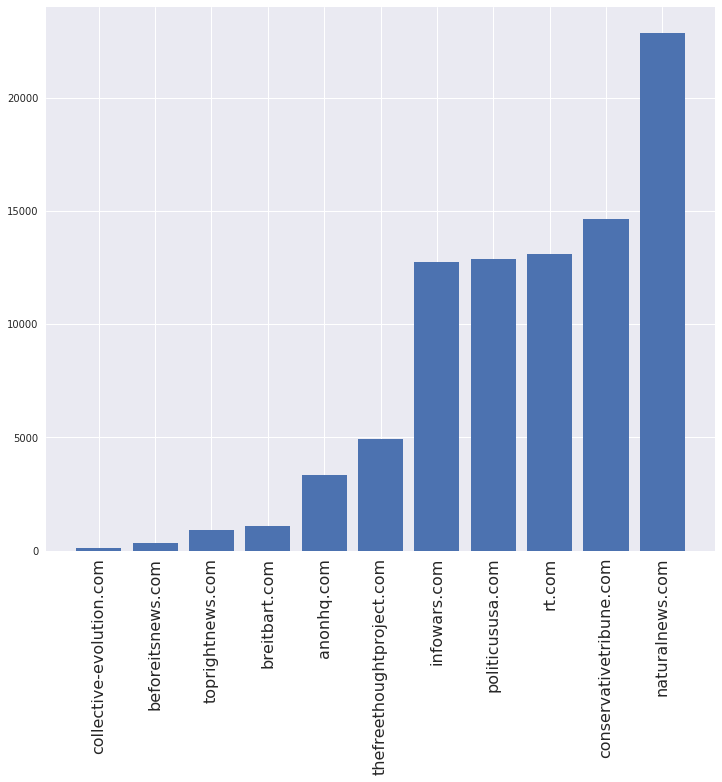

In [59]:
shared_data = shared_data[(shared_data.likes>0) | (shared_data.shares>0) | (shared_data.comments>0)]
shared_data_counts = shared_data.groupby('site_url').sum().sort_values(by=['shares'])
print(shared_data_counts.columns)
# Weird that likes and share are exactly the same number
plt.figure(figsize=(12,10))
plt.bar(left=[x for x in range(len(shared_data_counts.likes))], height = list(shared_data_counts.shares))
plt.xticks([x for x in range(len(shared_data_counts.likes))], list(shared_data_counts.index), rotation="vertical", fontsize=16)
plt.show()

(38, 20)

###